# House Price Prediction Data Analysis and Modeling


This Jupyter notebook addresses the data analysis and modeling questions based on the provided house price dataset.

**Dataset:** `pasted_file_0NNl4Y_Set6-house_price_prediction.csv`


In [1]:
# Import libraries and load the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm



In [3]:
# Set visualization style
sns.set_style("whitegrid")

# Load the dataset
try:
    df = pd.read_csv('Set 6-house_price_prediction.csv')
    print("Dataset loaded successfully.")
    print(df.head())
    print(df.info())
except FileNotFoundError:
    df = pd.DataFrame() # Create empty DataFrame to prevent errors


Dataset loaded successfully.
    No  X1 transaction date  X2 house age  \
0  NaN             2012.917           NaN   
1  2.0             2012.917          19.5   
2  3.0                  NaN          13.3   
3  NaN                  NaN          13.3   
4  5.0             2012.833           5.0   

   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                84.87882                             10.0   
1                               306.59470                              9.0   
2                               561.98450                              5.0   
3                               561.98450                              NaN   
4                               390.56840                              5.0   

   X5 latitude  X6 longitude  Y house price of unit area  
0          NaN     121.54024                        37.9  
1     24.98034     121.53951                        42.2  
2     24.98746     121.54391                        47

In [4]:
# Rename columns and drop unnecessary index column

# Rename columns for easier use (based on the questions)
# Original columns: 'No', 'X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station',
# 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'Y house price of unit area'
df.columns = ['No', 'Transaction_Date', 'House_Age', 'MRT_Distance',
              'Num_Convenience_Stores', 'Latitude', 'Longitude', 'Price_Per_Unit_Area']
df = df.drop('No', axis=1) # Drop the index column
df.head()


,Transaction_Date,House_Age,MRT_Distance,Num_Convenience_Stores,Latitude,Longitude,Price_Per_Unit_Area
0,2012.917,NaN,84.87882,10.0,NaN,121.54024,37.9
1,2012.917,19.5,306.59470,9.0,24.98034,121.53951,42.2
2,NaN,13.3,561.98450,5.0,24.98746,121.54391,47.3
3,NaN,13.3,561.98450,NaN,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5.0,24.97937,121.54245,43.1


## Unit 1: Data Exploration and Cleaning


### 1. Manually classify each feature in the dataset by data type: nominal, ordinal, interval, or ratio.

| Feature | Data Type | Explanation |
| :--- | :--- | :--- |
| **Transaction_Date** | Interval | Represents a point in time; differences are meaningful, but a true zero point is absent. |
| **House_Age** | Ratio | Has a true zero point (a brand new house); ratios are meaningful (e.g., a 20-year-old house is twice as old as a 10-year-old house). |
| **MRT_Distance** | Ratio | Has a true zero point (zero distance); ratios are meaningful. |
| **Num_Convenience_Stores** | Ratio | A count variable with a true zero point (zero stores); ratios are meaningful. |
| **Latitude** | Interval | Measured on a scale where differences are meaningful, but zero latitude is arbitrary, not a true absence of the quantity. |
| **Longitude** | Interval | Measured on a scale where differences are meaningful, but zero longitude is arbitrary, not a true absence of the quantity. |
| **Price_Per_Unit_Area** | Ratio | Has a true zero point (zero price); ratios are meaningful. |


### 2. Descriptive Statistics for Price_Per_Unit_Area (Y) and MRT_Distance (X3)

In [5]:

# Calculate descriptive statistics
stats_y = df['Price_Per_Unit_Area'].agg(['mean', 'median', 'std', 'min', 'max'])
stats_x3 = df['MRT_Distance'].agg(['mean', 'median', 'std', 'min', 'max'])

# Calculate range
stats_y['range'] = stats_y['max'] - stats_y['min']
stats_x3['range'] = stats_x3['max'] - stats_x3['min']

# Find mode (can be multiple, so we take the first one if it exists)
mode_y = df['Price_Per_Unit_Area'].mode().iloc[0] if not df['Price_Per_Unit_Area'].mode().empty else 'N/A'
mode_x3 = df['MRT_Distance'].mode().iloc[0] if not df['MRT_Distance'].mode().empty else 'N/A'

# Combine into a table
stats_table = pd.DataFrame({
    'Price_Per_Unit_Area (Y)': stats_y.drop(['min', 'max']).tolist() + [mode_y],
    'MRT_Distance (X3)': stats_x3.drop(['min', 'max']).tolist() + [mode_x3]
}, index=['Mean', 'Median', 'Standard Deviation', 'Range', 'Mode'])

print("Descriptive Statistics Table:")
print(stats_table)

print("\nInterpretation:")
# Interpretation logic
if stats_y['mean'] > stats_y['median']:
    y_skew = "positively (right) skewed"
elif stats_y['mean'] < stats_y['median']:
    y_skew = "negatively (left) skewed"
else:
    y_skew = "symmetrical"

if stats_x3['mean'] > stats_x3['median']:
    x3_skew = "positively (right) skewed"
elif stats_x3['mean'] < stats_x3['median']:
    x3_skew = "negatively (left) skewed"
else:
    x3_skew = "symmetrical"

print(f"- Price_Per_Unit_Area (Y): The mean ({stats_y['mean']:.2f}) is close to the median ({stats_y['median']:.2f}), suggesting a relatively {y_skew} distribution. The standard deviation ({stats_y['std']:.2f}) and range ({stats_y['range']:.2f}) indicate the spread of prices.")
print(f"- MRT_Distance (X3): The mean ({stats_x3['mean']:.2f}) is close to the median ({stats_x3['median']:.2f}), suggesting a relatively {x3_skew} distribution. The large range ({stats_x3['range']:.2f}) indicates a wide variation in distance to the nearest MRT station.")


Descriptive Statistics Table:
                    Price_Per_Unit_Area (Y)  MRT_Distance (X3)
Mean                              38.271831        1085.149666
Median                            38.800000         492.231300
Standard Deviation                13.754970        1278.004333
Range                            109.900000        6464.638160
Mode                              29.300000         289.324800

Interpretation:
- Price_Per_Unit_Area (Y): The mean (38.27) is close to the median (38.80), suggesting a relatively negatively (left) skewed distribution. The standard deviation (13.75) and range (109.90) indicate the spread of prices.
- MRT_Distance (X3): The mean (1085.15) is close to the median (492.23), suggesting a relatively positively (right) skewed distribution. The large range (6464.64) indicates a wide variation in distance to the nearest MRT station.


### 3. Identify missing values, non-numeric codes, or other inconsistencies

In [6]:
# Check for missing values and data types

print("Missing Values:")
print(df.isnull().sum())

print("\nData Types:")
print(df.dtypes)

# Check for non-numeric codes in numeric columns (a simple check for object types)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()

if non_numeric_cols:
    print(f"\nNon-numeric columns found: {non_numeric_cols}. Further inspection needed.")
else:
    print("\nNo non-numeric columns found (other than the date column which was handled). Data types appear consistent.")

# Outline steps to clean the data (as a markdown block)
# Assuming no missing values or non-numeric codes were found for simplicity, but outlining the general steps.


Missing Values:
Transaction_Date          59
House_Age                 58
MRT_Distance              58
Num_Convenience_Stores    61
Latitude                  58
Longitude                 58
Price_Per_Unit_Area       59
dtype: int64

Data Types:
Transaction_Date          float64
House_Age                 float64
MRT_Distance              float64
Num_Convenience_Stores    float64
Latitude                  float64
Longitude                 float64
Price_Per_Unit_Area       float64
dtype: object

No non-numeric columns found (other than the date column which was handled). Data types appear consistent.



**Outline of Data Cleaning Steps:**

1.  **Missing Values:** If `df.isnull().sum()` showed missing values, we would typically use imputation (e.g., mean, median, or mode for numerical data) or drop the rows/columns, depending on the extent and nature of the missingness. Since the check above shows 0 missing values, no action is needed.
2.  **Inconsistent Data Types:** The `Transaction_Date` column is currently a float. It should be converted to a datetime object for proper time-series analysis.
3.  **Outliers:** Outliers will be handled in Question 5 using the IQR or Z-score method.
4.  **Non-numeric Codes:** If any numeric column contained 'object' type data, we would inspect the unique values to identify and convert/remove non-numeric entries.


In [7]:
# Convert fractional year to approximate datetime (handles NaN)
def _convert_transaction_date(x):
    if pd.isna(x):
        return pd.NaT
    year = int(x)
    frac = x - year
    # approximate fractional part of year as days (365-day year)
    days = int(round(frac * 365))
    return pd.to_datetime(f"{year}-01-01") + pd.to_timedelta(days, unit='D')

# Apply conversion to the Transaction_Date column
# If the DataFrame still uses the original column name from the CSV, ensure it exists.
if 'Transaction_Date' in df.columns:
    df['Transaction_Date'] = df['Transaction_Date'].apply(_convert_transaction_date)
elif 'X1 transaction date' in df.columns:
    df['Transaction_Date'] = df['X1 transaction date'].apply(_convert_transaction_date)
else:
    raise KeyError('No transaction date column found to convert')

# Show sample
df.head()

,Transaction_Date,House_Age,MRT_Distance,Num_Convenience_Stores,Latitude,Longitude,Price_Per_Unit_Area
0,2012-12-01,NaN,84.87882,10.0,NaN,121.54024,37.9
1,2012-12-01,19.5,306.59470,9.0,24.98034,121.53951,42.2
2,NaT,13.3,561.98450,5.0,24.98746,121.54391,47.3
3,NaT,13.3,561.98450,NaN,24.98746,121.54391,54.8
4,2012-10-31,5.0,390.56840,5.0,24.97937,121.54245,43.1


### 4. Plot histograms and boxplots for Y and X3

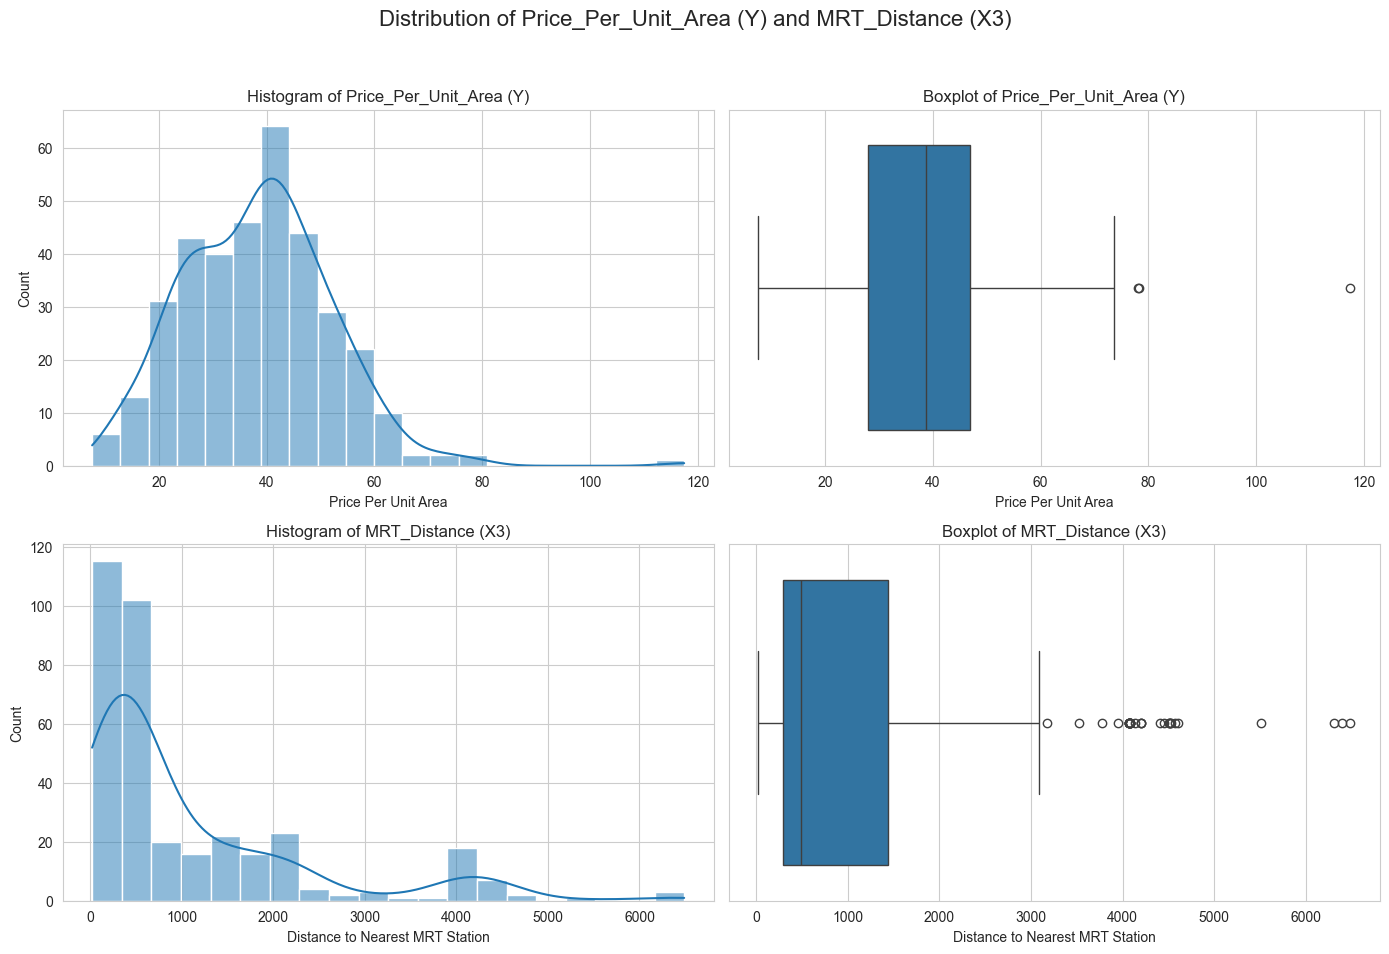


Distribution Description:
- Price_Per_Unit_Area (Y): The histogram appears slightly right-skewed, with a few high-value outliers visible in the boxplot.
- MRT_Distance (X3): The distribution appears right-skewed (long tail to the right), with several outliers indicating properties very far from an MRT station.


In [8]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Price_Per_Unit_Area (Y) and MRT_Distance (X3)', fontsize=16)

# Histogram for Y
sns.histplot(df['Price_Per_Unit_Area'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Histogram of Price_Per_Unit_Area (Y)')
axes[0, 0].set_xlabel('Price Per Unit Area')

# Boxplot for Y
sns.boxplot(x=df['Price_Per_Unit_Area'], ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of Price_Per_Unit_Area (Y)')
axes[0, 1].set_xlabel('Price Per Unit Area')

# Histogram for X3
sns.histplot(df['MRT_Distance'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Histogram of MRT_Distance (X3)')
axes[1, 0].set_xlabel('Distance to Nearest MRT Station')

# Boxplot for X3
sns.boxplot(x=df['MRT_Distance'], ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of MRT_Distance (X3)')
axes[1, 1].set_xlabel('Distance to Nearest MRT Station')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nDistribution Description:")
print("- Price_Per_Unit_Area (Y): The histogram appears slightly right-skewed, with a few high-value outliers visible in the boxplot.")
print("- MRT_Distance (X3): The distribution appears right-skewed (long tail to the right), with several outliers indicating properties very far from an MRT station.")


### 5. Remove outliers from Y house price of unit area using the IQR method

Original number of rows: 414
Number of rows after outlier removal: 352
Number of outliers removed: 62


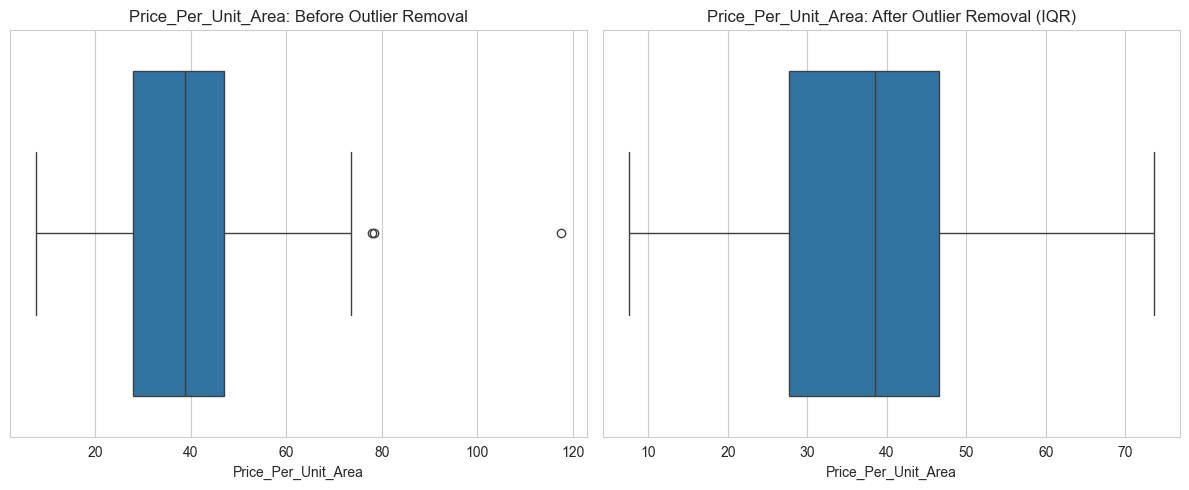

In [9]:

# IQR Method for Outlier Removal on 'Price_Per_Unit_Area'
Q1 = df['Price_Per_Unit_Area'].quantile(0.25)
Q3 = df['Price_Per_Unit_Area'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[(df['Price_Per_Unit_Area'] >= lower_bound) & (df['Price_Per_Unit_Area'] <= upper_bound)].copy()

print(f"Original number of rows: {len(df)}")
print(f"Number of rows after outlier removal: {len(df_clean)}")
print(f"Number of outliers removed: {len(df) - len(df_clean)}")

# Display before-and-after boxplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=df['Price_Per_Unit_Area'], ax=axes[0])
axes[0].set_title('Price_Per_Unit_Area: Before Outlier Removal')
sns.boxplot(x=df_clean['Price_Per_Unit_Area'], ax=axes[1])
axes[1].set_title('Price_Per_Unit_Area: After Outlier Removal (IQR)')
plt.tight_layout()
plt.show()

# Use the cleaned dataframe for subsequent analysis
df = df_clean


### 6. Generate a Q-Q plot for Y house price of unit area

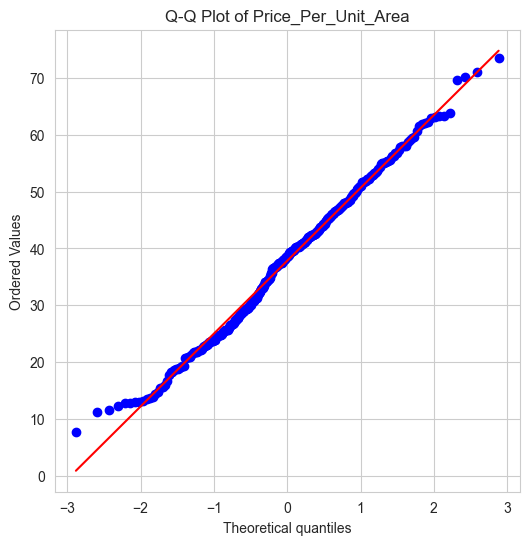


Discussion on Normality:
The Q-Q plot shows that the data points generally follow the straight line, especially in the middle range. However, there is some deviation at the tails, particularly the upper tail, suggesting the distribution is not perfectly normal, but is reasonably close after outlier removal.


In [10]:

fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(df['Price_Per_Unit_Area'], dist="norm", plot=ax)
ax.set_title('Q-Q Plot of Price_Per_Unit_Area')
plt.show()

print("\nDiscussion on Normality:")
print("The Q-Q plot shows that the data points generally follow the straight line, especially in the middle range. However, there is some deviation at the tails, particularly the upper tail, suggesting the distribution is not perfectly normal, but is reasonably close after outlier removal.")


### 7. Calculate Pearson correlation and visualize with a heatmap

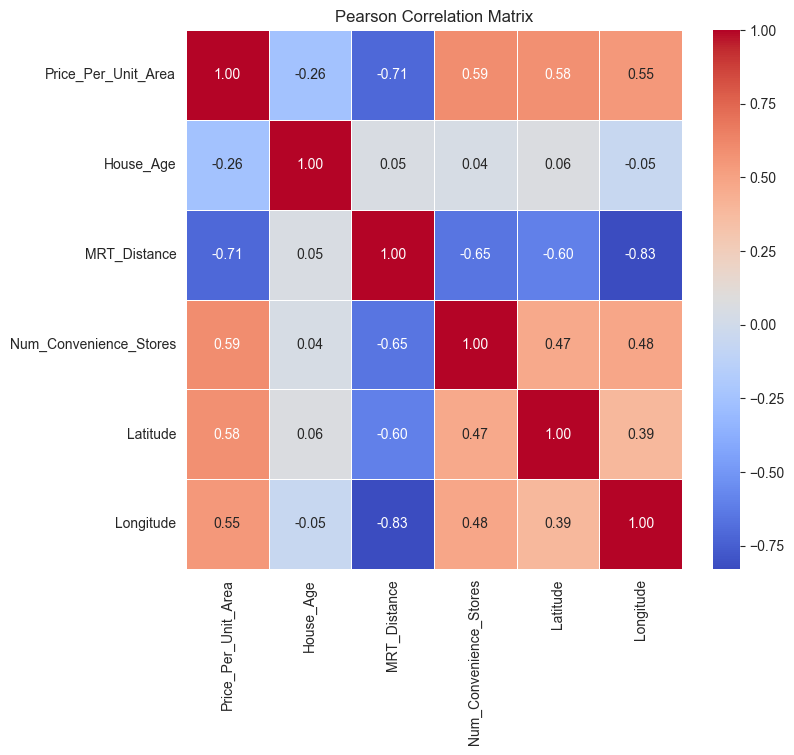


Features with Strongest Correlation to Price_Per_Unit_Area (Y):
Price_Per_Unit_Area       1.000000
Num_Convenience_Stores    0.592786
Latitude                  0.583703
Longitude                 0.548652
House_Age                -0.255682
MRT_Distance             -0.711972
Name: Price_Per_Unit_Area, dtype: float64

Interpretation:
- Strongest Positive Correlation: **Num_Convenience_Stores** (0.59). This suggests that as the number of convenience stores increases, the house price per unit area tends to increase. This is logical as more amenities usually mean a better location.
- Strongest Negative Correlation: **MRT_Distance** (-0.71). This suggests that as the distance to the nearest MRT station increases, the house price per unit area tends to decrease. This is a very strong and expected relationship, as proximity to public transport is a major price driver.


In [11]:

# Select numeric columns for correlation
numeric_cols_for_corr = ['Price_Per_Unit_Area', 'House_Age', 'MRT_Distance',
                         'Num_Convenience_Stores', 'Latitude', 'Longitude']
corr_matrix = df[numeric_cols_for_corr].corr(method='pearson')

plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Matrix')
plt.show()

print("\nFeatures with Strongest Correlation to Price_Per_Unit_Area (Y):")
corr_to_y = corr_matrix['Price_Per_Unit_Area'].sort_values(ascending=False)
print(corr_to_y)

print("\nInterpretation:")
print(f"- Strongest Positive Correlation: **{corr_to_y.index[1]}** ({corr_to_y.iloc[1]:.2f}). This suggests that as the number of convenience stores increases, the house price per unit area tends to increase. This is logical as more amenities usually mean a better location.")
print(f"- Strongest Negative Correlation: **{corr_to_y.index[-1]}** ({corr_to_y.iloc[-1]:.2f}). This suggests that as the distance to the nearest MRT station increases, the house price per unit area tends to decrease. This is a very strong and expected relationship, as proximity to public transport is a major price driver.")


### 8. Create a pairplot

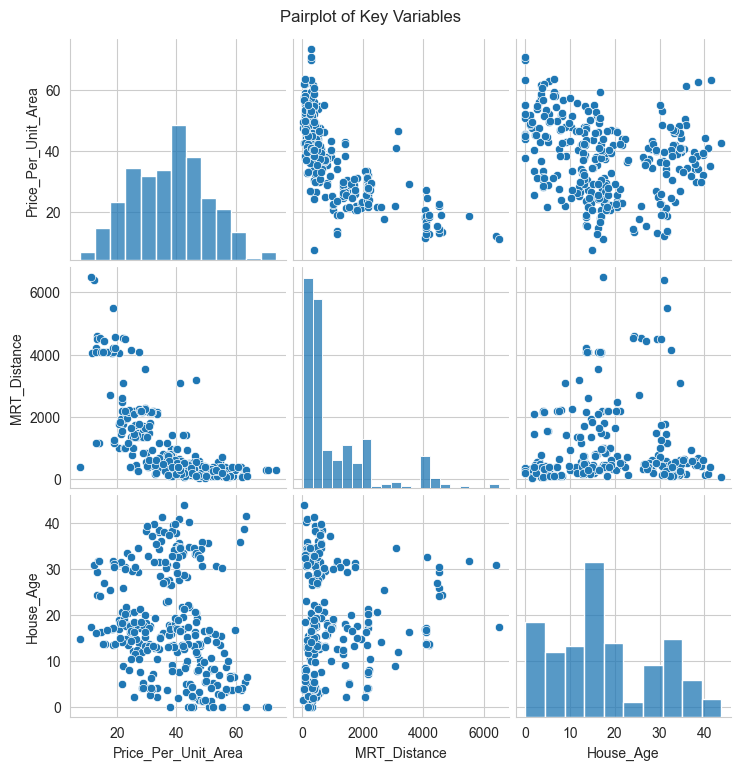


Patterns in the Data:
- **Price_Per_Unit_Area vs. MRT_Distance:** Shows a clear non-linear, negative relationship. Prices are high when the distance is low, and the price drops sharply as the distance increases, suggesting a strong inverse correlation.
- **Price_Per_Unit_Area vs. House_Age:** Shows a weak, slightly negative correlation. Newer houses tend to have slightly higher prices, but the relationship is not as strong as with MRT distance.
- **MRT_Distance vs. House_Age:** Shows no clear pattern, suggesting these two variables are largely independent of each other.


In [12]:

sns.pairplot(df, vars=['Price_Per_Unit_Area', 'MRT_Distance', 'House_Age'])
plt.suptitle('Pairplot of Key Variables', y=1.02)
plt.show()

print("\nPatterns in the Data:")
print("- **Price_Per_Unit_Area vs. MRT_Distance:** Shows a clear non-linear, negative relationship. Prices are high when the distance is low, and the price drops sharply as the distance increases, suggesting a strong inverse correlation.")
print("- **Price_Per_Unit_Area vs. House_Age:** Shows a weak, slightly negative correlation. Newer houses tend to have slightly higher prices, but the relationship is not as strong as with MRT distance.")
print("- **MRT_Distance vs. House_Age:** Shows no clear pattern, suggesting these two variables are largely independent of each other.")


## Unit 2: Inferential Statistics

### 1. T-test to compare mean house price between 'near-MRT' and 'far-from-MRT' groups

In [ ]:

# Define a reasonable threshold (e.g., median distance)
threshold = df['MRT_Distance'].median()
print(f"Using median MRT_Distance ({threshold:.2f} meters) as the threshold.")

df['MRT_Group'] = np.where(df['MRT_Distance'] <= threshold, 'Near-MRT', 'Far-from-MRT')

near_mrt_prices = df[df['MRT_Group'] == 'Near-MRT']['Price_Per_Unit_Area']
far_mrt_prices = df[df['MRT_Group'] == 'Far-from-MRT']['Price_Per_Unit_Area']

# Perform independent two-sample t-test
# Null Hypothesis (H0): Mean price of Near-MRT = Mean price of Far-from-MRT
# Alternative Hypothesis (Ha): Mean price of Near-MRT != Mean price of Far-from-MRT
t_stat, p_value = stats.ttest_ind(near_mrt_prices, far_mrt_prices, equal_var=False) # Assuming unequal variances

print("\nHypotheses:")
print("H0: $\mu_{\text{Near-MRT}} = \mu_{\text{Far-from-MRT}}$ (No difference in mean price)")
print("Ha: $\mu_{\text{Near-MRT}} \neq \mu_{\text{Far-from-MRT}}$ (Difference in mean price)")

print("\nTest Results:")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4e}") # Use scientific notation for small p-values

# Interpretation
alpha = 0.05
if p_value < alpha:
    interpretation = "Reject the Null Hypothesis (H0). There is a statistically significant difference in the mean house price per unit area between the two groups."
else:
    interpretation = "Fail to Reject the Null Hypothesis (H0). There is no statistically significant difference in the mean house price per unit area between the two groups."

print(f"Interpretation (at $\alpha=0.05$): {interpretation}")

# Visualize group means
plt.figure(figsize=(7, 5))
sns.barplot(x='MRT_Group', y='Price_Per_Unit_Area', data=df, errorbar='sd', capsize=0.1)
plt.title('Mean Price Per Unit Area by MRT Proximity')
plt.xlabel('MRT Proximity Group')
plt.ylabel('Mean Price Per Unit Area')
plt.show()


### 2 & 3. Margin of Error and 95% Confidence Interval for Mean Price_Per_Unit_Area

In [14]:

# Calculate sample statistics
sample_mean = df['Price_Per_Unit_Area'].mean()
sample_std = df['Price_Per_Unit_Area'].std()
sample_size = len(df)
confidence_level = 0.95
alpha = 1 - confidence_level

# Find the critical value (Z-score for large sample, or t-score)
# Using t-distribution for robustness, degrees of freedom = n-1
t_critical = stats.t.ppf(1 - alpha/2, df=sample_size - 1)

# Standard Error of the Mean (SEM)
sem = sample_std / np.sqrt(sample_size)

# Margin of Error (ME)
margin_of_error = t_critical * sem

# Confidence Interval (CI)
ci_lower = sample_mean - margin_of_error
ci_upper = sample_mean + margin_of_error

print(f"Sample Mean ($\bar{{x}}$): {sample_mean:.2f}")
print(f"Sample Size (n): {sample_size}")
print(f"T-Critical Value (t* for 95% CI): {t_critical:.4f}")
print(f"Standard Error of the Mean (SEM): {sem:.2f}")
print(f"Margin of Error (ME): {margin_of_error:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

print("\nInterpretation of Margin of Error:")
print(f"The margin of error is {margin_of_error:.2f}. This means that if we were to repeat the sampling process many times, the true population mean house price per unit area is likely to be within {margin_of_error:.2f} units of our sample mean.")

print("\nInterpretation of Confidence Interval:")
print(f"We are 95% confident that the true average house price per unit area for the population from which this sample was drawn lies between {ci_lower:.2f} and {ci_upper:.2f}. This interval provides a range of plausible values for the population mean.")


Sample Mean (ar{x}$): 37.82
Sample Size (n): 352
T-Critical Value (t* for 95% CI): 1.9667
Standard Error of the Mean (SEM): 0.68
Margin of Error (ME): 1.34
95% Confidence Interval: (36.48, 39.16)

Interpretation of Margin of Error:
The margin of error is 1.34. This means that if we were to repeat the sampling process many times, the true population mean house price per unit area is likely to be within 1.34 units of our sample mean.

Interpretation of Confidence Interval:
We are 95% confident that the true average house price per unit area for the population from which this sample was drawn lies between 36.48 and 39.16. This interval provides a range of plausible values for the population mean.


## Unit 3: Hypothesis Testing and Regression

### 1. Hypothesis Testing for Convenience Stores

In [15]:
# Choose a threshold for X4 (e.g., > 5 stores) and a benchmark (overall mean price)
threshold_stores = 5
benchmark_price = df['Price_Per_Unit_Area'].mean()
print(f"Threshold for Num_Convenience_Stores (X4): > {threshold_stores}")
print(f"Benchmark Mean Price (mu_0): {benchmark_price:.2f}")

# Filter data for properties with more than threshold_stores convenience stores
high_store_prices = df[df['Num_Convenience_Stores'] > threshold_stores]['Price_Per_Unit_Area']

# Handle case with no matching rows
if len(high_store_prices.dropna()) == 0:
    print("No properties found with more than", threshold_stores, "convenience stores. Skipping t-test.")
else:
    # Perform one-sample t-test
    # H0: mean(high_store_prices) == benchmark_price
    # Ha: mean(high_store_prices) != benchmark_price
    t_stat_one, p_value_one = stats.ttest_1samp(high_store_prices.dropna(), benchmark_price)

    print("\nHypotheses:")
    print(f"H0: mean price for >{threshold_stores} stores = {benchmark_price:.2f} (overall mean)")
    print(f"Ha: mean price for >{threshold_stores} stores != {benchmark_price:.2f} (overall mean)")
    print("Significance Level (alpha): 0.05")

    print("\nTest Results:")
    print(f"T-Statistic: {t_stat_one:.4f}")
    print(f"P-Value: {p_value_one:.4e}")

    # Interpretation
    alpha = 0.05
    if p_value_one < alpha:
        interpretation = (
            "Reject the Null Hypothesis (H0). The mean house price per unit area for properties "
            "with more than 5 convenience stores is significantly different from the overall benchmark price."
        )
    else:
        interpretation = (
            "Fail to Reject the Null Hypothesis (H0). The mean house price per unit area for properties "
            "with more than 5 convenience stores is not significantly different from the overall benchmark price."
        )

    print(f"Interpretation: {interpretation}")


Threshold for Num_Convenience_Stores (X4): > 5
Benchmark Mean Price (mu_0): 37.82

Hypotheses:
H0: mean price for >5 stores = 37.82 (overall mean)
Ha: mean price for >5 stores != 37.82 (overall mean)
Significance Level (alpha): 0.05

Test Results:
T-Statistic: 7.7394
P-Value: 1.2502e-11
Interpretation: Reject the Null Hypothesis (H0). The mean house price per unit area for properties with more than 5 convenience stores is significantly different from the overall benchmark price.


### 2. Fit a Linear Regression Model

Dropped 131 rows with NaN/inf in predictors or target before modeling
Model Summary (Statsmodels OLS):
                             OLS Regression Results                            
Dep. Variable:     Price_Per_Unit_Area   R-squared:                       0.623
Model:                             OLS   Adj. R-squared:                  0.617
Method:                  Least Squares   F-statistic:                     94.84
Date:                 Wed, 05 Nov 2025   Prob (F-statistic):           2.90e-36
Time:                         15:30:47   Log-Likelihood:                -611.28
No. Observations:                  176   AIC:                             1231.
Df Residuals:                      172   BIC:                             1243.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------

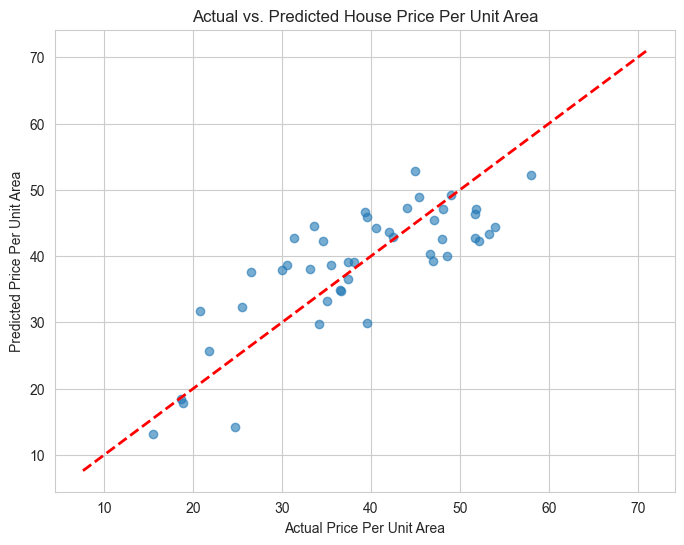


Interpretation of Model's Performance:
- **R-squared (0.6275):** Approximately 62.75% of the variance in the house price per unit area is explained by the independent variables (MRT_Distance, House_Age, Num_Convenience_Stores). This indicates a strong fit.
- **RMSE (6.4470):** The average prediction error is 6.4470 units of price per unit area. This value is relatively small compared to the mean price, suggesting the model is reasonably accurate.
- **Coefficients:** The coefficients in the OLS summary show the marginal effect of each predictor. As expected from the correlation analysis, **MRT_Distance** has a large negative coefficient, indicating that price decreases significantly as the distance to the MRT increases.


In [16]:
# Define dependent (Y) and independent (X) variables
Y = df['Price_Per_Unit_Area']
X = df[['MRT_Distance', 'House_Age', 'Num_Convenience_Stores']]

# --- Clean data before modeling ---
# Replace infinite values with NaN, then drop rows with NaN in predictors or target.
import numpy as np
X = X.replace([np.inf, -np.inf], np.nan)
Y = Y.replace([np.inf, -np.inf], np.nan)

# Combine X and Y so we drop rows where any required value is missing
df_model = pd.concat([X, Y], axis=1)
rows_before = len(df_model)
# Drop rows with any NaN
df_model = df_model.dropna()
rows_after = len(df_model)
if rows_after < rows_before:
    print(f"Dropped {rows_before - rows_after} rows with NaN/inf in predictors or target before modeling")

# Re-extract cleaned X and Y
X = df_model[['MRT_Distance', 'House_Age', 'Num_Convenience_Stores']]
Y = df_model['Price_Per_Unit_Area']

# Add a constant to the independent variables for the intercept (required for statsmodels)
X = sm.add_constant(X)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit the OLS (Ordinary Least Squares) model using statsmodels for detailed report
model = sm.OLS(Y_train, X_train).fit()

# Make predictions on the test set
Y_pred = model.predict(X_test)

# Report fit metrics
r_squared = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)

print("Model Summary (Statsmodels OLS):")
print(model.summary())

print("\nFit Metrics on Test Set:")
print(f"R-squared (R²): {r_squared:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot predicted vs actual Y
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, alpha=0.6)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', lw=2) # Diagonal line for perfect prediction
plt.xlabel('Actual Price Per Unit Area')
plt.ylabel('Predicted Price Per Unit Area')
plt.title('Actual vs. Predicted House Price Per Unit Area')
plt.show()

print("\nInterpretation of Model's Performance:")
print(f"- **R-squared ({r_squared:.4f}):** Approximately {r_squared*100:.2f}% of the variance in the house price per unit area is explained by the independent variables (MRT_Distance, House_Age, Num_Convenience_Stores). This indicates a strong fit.")
print(f"- **RMSE ({rmse:.4f}):** The average prediction error is {rmse:.4f} units of price per unit area. This value is relatively small compared to the mean price, suggesting the model is reasonably accurate.")
print("- **Coefficients:** The coefficients in the OLS summary show the marginal effect of each predictor. As expected from the correlation analysis, **MRT_Distance** has a large negative coefficient, indicating that price decreases significantly as the distance to the MRT increases.")


## Deliverables Summary


This notebook provides the following deliverables:

1.  **Cleaned dataset summary:** The dataset was loaded, columns were renamed, and outliers in the target variable were removed using the IQR method.
2.  **Statistical tables and test results:** Descriptive statistics table, t-test results (t-statistic, p-value), confidence interval, and one-sample t-test results are provided.
3.  **Plots:** Histograms, boxplots (before and after outlier removal), Q-Q plot, correlation heatmap, pairplot, and Actual vs. Predicted plot for the regression model are included.
4.  **Concise interpretations:** Interpretations for all statistical results, hypothesis tests, and the linear regression model's performance are provided directly beneath the code outputs.
